Found 840 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 117 images belonging to 3 classes.


C:\Users\kaush\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5452 - loss: 1.1267
Epoch 1: val_accuracy improved from -inf to 0.90476, saving model to C:\Users\kaush\Downloads\face\best_face_shape_mobilenet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 627ms/step - accuracy: 0.5493 - loss: 1.1160 - val_accuracy: 0.9048 - val_loss: 0.3206
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9145 - loss: 0.2448
Epoch 2: val_accuracy improved from 0.90476 to 0.94286, saving model to C:\Users\kaush\Downloads\face\best_face_shape_mobilenet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.9145 - loss: 0.2444 - val_accuracy: 0.9429 - val_loss: 0.1785
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9559 - loss: 0.1449
Epoch 3: val_accuracy improved from 0.94286 to 0.95238, saving model to C:\Users\kaush\Downloads\face\best_face_shape_mobilenet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.9562 - loss: 0.1445 - val_accuracy:

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 1.0000 - loss: 0.0063
Test Loss: 0.007227062247693539
Test Accuracy: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step
Classification Report:
                     precision    recall  f1-score   support

Rounded_Double_Chin       1.00      1.00      1.00         9
Tapering_Triangular       1.00      1.00      1.00        77
       Thin_Angular       1.00      1.00      1.00        31

           accuracy                           1.00       117
          macro avg       1.00      1.00      1.00       117
       weighted avg       1.00      1.00      1.00       117

Confusion Matrix:
[[ 9  0  0]
 [ 0 77  0]
 [ 0  0 31]]


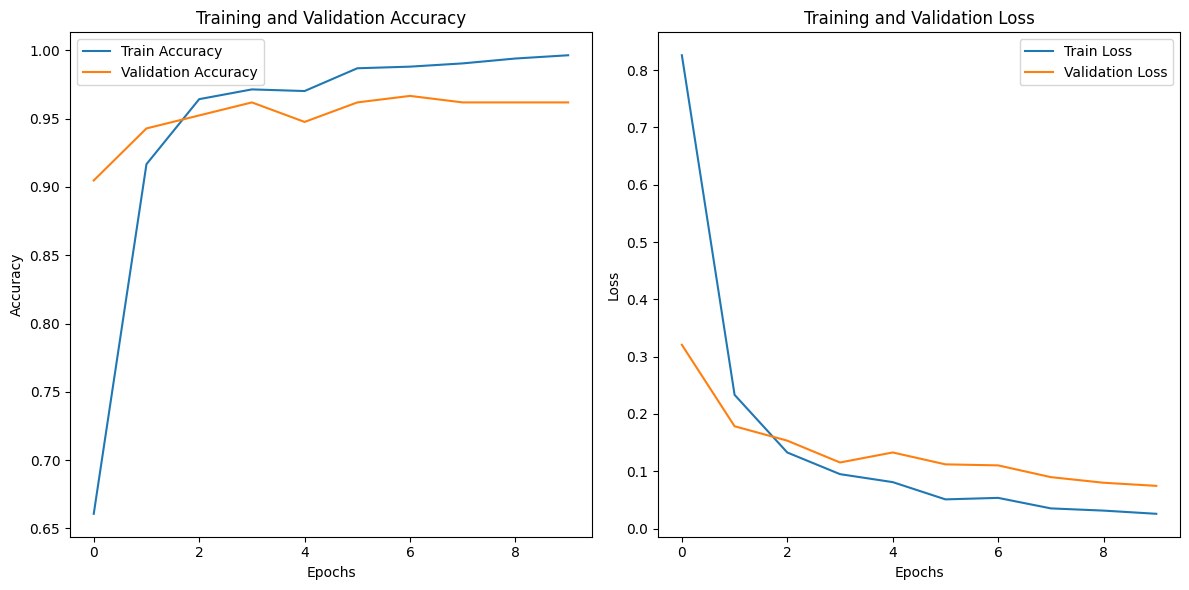

Model training, evaluation, and history saving complete.


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, History
import matplotlib.pyplot as plt
import pickle

# Directories for the augmented dataset classes
augmented_dataset_dir = r'C:/Users/kaush/Downloads/FACE_IMPLEMENTATION/face_shape dataset/augmented_dataset'
rounded_double_chin_dir = os.path.join(augmented_dataset_dir, 'Rounded_Double_Chin')
tapering_triangular_dir = os.path.join(augmented_dataset_dir, 'Tapering_Triangular')
thin_angular_dir = os.path.join(augmented_dataset_dir, 'Thin_Angular')

# Parameters
img_size = (128, 128)
batch_size = 32

# Data generators for augmented dataset (training and validation split)
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    augmented_dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    augmented_dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data generator for testing with unaugmented dataset
unaugmented_test_dir = r'C:\Users\kaush\Downloads\face\dataset'
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    unaugmented_test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model creation using MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)  # 3 output classes

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the checkpoint to save the best MobileNet model with .keras extension
checkpoint_path = r'C:\Users\kaush\Downloads\face\best_face_shape_mobilenet_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',
    verbose=1
)

# Define History to save model training history
history = History()

# Train the model with the checkpoint and history callback
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[model_checkpoint, history]
)

# Save the final model with .h5 extension after training
model.save(r'C:\Users\kaush\Downloads\face\face_shape_mobilenet_model_final.h5')

# Evaluate the model on the unaugmented test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate classification report and confusion matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# Save the training history to a file
history_path = r'C:\Users\kaush\Downloads\face\training_history_mobilenet.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Model training, evaluation, and history saving complete.")


Found 840 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 117 images belonging to 3 classes.
Epoch 1/10


C:\Users\kaush\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.5774 - loss: 1.1276
Epoch 1: val_accuracy improved from -inf to 0.89048, saving model to C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\best_face_shape_mobilenet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - accuracy: 0.5823 - loss: 1.1140 - val_accuracy: 0.8905 - val_loss: 0.3015
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8905 - loss: 0.2814
Epoch 2: val_accuracy improved from 0.89048 to 0.94286, saving model to C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\best_face_shape_mobilenet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - accuracy: 0.8909 - loss: 0.2804 - val_accuracy: 0.9429 - val_loss: 0.1940
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9587 - loss: 0.1241
Epoch 3: val_accuracy improved from 0.94286 to 0.94762, saving model to C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\best_face_shape_mobilenet_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.9

Model saved at: C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\face_shape_mobilenet_model_final.h5
Best model checkpoint saved at: C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\best_face_shape_mobilenet_model.keras
Training history saved at: C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\training_history_mobilenet.pkl
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9914 - loss: 0.0122
Test Loss: 0.012855160981416702
Test Accuracy: 0.9914529919624329
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step
Classification Report:
                     precision    recall  f1-score   support

Rounded_Double_Chin       1.00      1.00      1.00         9
Tapering_Triangular       1.00      0.99      0.99        77
       Thin_Angular       0.97      1.00      0.98        31

           accuracy                           0.99       117
          macro avg       0.99      1.00      0.99       117
       weighted avg       0.99      0.99      0.99       117

Confusion Matrix:
[[ 9  0  0]
 [ 0 76  1]
 [ 0  0 31]]

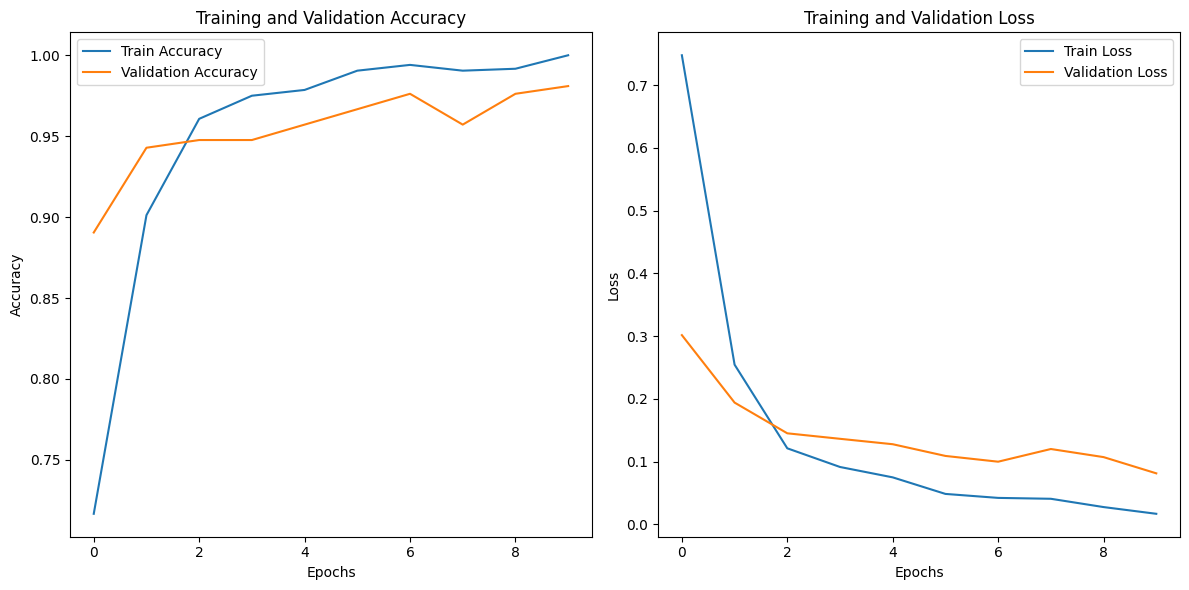

Model training, evaluation, and history saving complete.


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, History
import matplotlib.pyplot as plt
import pickle

# Directories for the augmented dataset classes
augmented_dataset_dir = r'C:/Users/kaush/Downloads/FACE_IMPLEMENTATION/face_shape dataset/augmented_dataset'
rounded_double_chin_dir = os.path.join(augmented_dataset_dir, 'Rounded_Double_Chin')
tapering_triangular_dir = os.path.join(augmented_dataset_dir, 'Tapering_Triangular')
thin_angular_dir = os.path.join(augmented_dataset_dir, 'Thin_Angular')

# Parameters
img_size = (128, 128)
batch_size = 32

# Data generators for augmented dataset (training and validation split)
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    augmented_dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    augmented_dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Data generator for testing with unaugmented dataset
unaugmented_test_dir = r'C:\Users\kaush\Downloads\face\dataset'
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    unaugmented_test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model creation using MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)  # 3 output classes

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Updated paths for saving model and history
checkpoint_path = r'C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\best_face_shape_mobilenet_model.keras'
final_model_path = r'C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\face_shape_mobilenet_model_final.h5'
history_path = r'C:\Users\kaush\Downloads\FACE_IMPLEMENTATION\training_history_mobilenet.pkl'

# Define the checkpoint to save the best MobileNet model with .keras extension
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',
    verbose=1
)

# Define History to save model training history
history = History()

# Train the model with the checkpoint and history callback
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[model_checkpoint, history]
)

# Save the final model with .h5 extension after training
model.save(final_model_path)

# Save the training history to a file
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

print("Model saved at:", final_model_path)
print("Best model checkpoint saved at:", checkpoint_path)
print("Training history saved at:", history_path)

# Evaluate the model on the unaugmented test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generate classification report and confusion matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Model training, evaluation, and history saving complete.")


In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/FACE_IMPLEMENTATION/face_shape dataset/augmented_dataset'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/FACE_IMPLEMENTATION/preprocessed_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/FACE_IMPLEMENTATION/preprocessed_dataset


In [12]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/FACE_IMPLEMENTATION/face_shape dataset/dataset'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/FACE_IMPLEMENTATION/preprocessed_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/FACE_IMPLEMENTATION/preprocessed_dataset


In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/EYES_IMPLEMENTATION/eyes dataset/train'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/EYES_IMPLEMENTATION/preprocessed_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/EYES_IMPLEMENTATION/preprocessed_dataset


In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/HAIR_IMPLEMENTATION/hair dataset/training'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/HAIR_IMPLEMENTATION/preprocessed_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/HAIR_IMPLEMENTATION/preprocessed_dataset


In [13]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/HAIR_IMPLEMENTATION/hair dataset/testing'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/HAIR_IMPLEMENTATION/preprocessed_testing_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/HAIR_IMPLEMENTATION/preprocessed_testing_dataset


In [7]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/LIPS_IMPLRMENTATION/lips dataset/augmented_train'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/LIPS_IMPLEMENTATION/preprocessed_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/LIPS_IMPLEMENTATION/preprocessed_dataset


In [11]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/LIPS_IMPLRMENTATION/lips dataset/testing'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/LIPS_IMPLEMENTATION/preprocessed_testing_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/LIPS_IMPLEMENTATION/preprocessed_testing_dataset


In [8]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/SKIN_IMPLEMENTATION/skin dataset/augmented_train'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/SKIN_IMPLEMENTATION/preprocessed_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/SKIN_IMPLEMENTATION/preprocessed_dataset


In [10]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
input_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/SKIN_IMPLEMENTATION/skin dataset/train1'
output_dir = r'C:/Users/kaush/Downloads/IMPLEMENTATIONS/SKIN_IMPLEMENTATION/preprocessed_train1_dataset'

# Parameters
img_size = (128, 128)  # Target size for preprocessing
rescale_factor = 1.0 / 255  # Rescale images to [0, 1]

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Data generator for preprocessing (only rescaling in this case)
datagen = ImageDataGenerator(rescale=rescale_factor)

# Iterate over the folders (classes) in the input directory
for class_name in os.listdir(input_dir):
    class_input_dir = os.path.join(input_dir, class_name)
    class_output_dir = os.path.join(output_dir, class_name)

    # Create the output directory for the class if it doesn't exist
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Process each image in the class folder
    for image_name in os.listdir(class_input_dir):
        image_path = os.path.join(class_input_dir, image_name)
        if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Skip non-image files
            continue

        # Read and preprocess the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        image = cv2.resize(image, img_size)  # Resize to target size
        image = image * rescale_factor  # Rescale pixel values to [0, 1]

        # Save the preprocessed image to the output folder
        output_path = os.path.join(class_output_dir, image_name)
        image = (image * 255).astype(np.uint8)  # Convert back to [0, 255] for saving
        cv2.imwrite(output_path, image)

print("Preprocessed images saved in:", output_dir)


Preprocessed images saved in: C:/Users/kaush/Downloads/IMPLEMENTATIONS/SKIN_IMPLEMENTATION/preprocessed_train1_dataset
